In [430]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
import scipy
import math
import zlib
import random
from scipy import stats
from scipy import signal
from collections import Counter
from itertools import *
sns.plt = plt
np.random.seed(1) # No estoy seguro si es necesario

In [228]:
# Carga de datos

# datasets_sujetos: (Sujeto x Epoch x Electrodo x Tiempo -> Valor)
datasets_sujetos = []

# # Solo 2 datasets, para probar
# datasets_sujetos.append(scipy.io.loadmat('datos/S01.mat')['data'])
# datasets_sujetos.append(scipy.io.loadmat('datos/P01.mat')['data'])

# Normales
for i in range(1,10):
    datasets_sujetos.append(scipy.io.loadmat('datos/S0'+str(i)+'.mat')['data'])
datasets_sujetos.append(scipy.io.loadmat('datos/S10.mat')['data'])

# Disminuidos
for i in range(1,10):
    datasets_sujetos.append(scipy.io.loadmat('datos/P0'+str(i)+'.mat')['data'])
datasets_sujetos.append(scipy.io.loadmat('datos/P10.mat')['data'])

In [410]:
print 'Se cargaron '+ str(len(datasets_sujetos)) + ' datasets.'

Se cargaron 20 datasets.


In [520]:
# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor)
# devuelve la cantidad de epochs
def epoch_count(dataset):
    return len(dataset)

def random_epochs(dataset, count):
    return random.sample(range(0, epoch_count(dataset)), count)

# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor)
# devuelve la cantidad de electrodos
def electrodos_count(dataset):
    return len(dataset[0])

def random_electrodes(dataset, count):
    return random.sample(range(0, electrodos_count(dataset)), count)

# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor)
# devuelve la cantidad de tiempos
def tiempo_count(dataset):
    return len(dataset[0][0])

In [521]:
# Dada una lista zipeada de [(a,b)] devuelve una tupla de lista ([a],[b])
def unzip(iterable):
    return zip(*iterable)

# Dadas dos listas de freqs y pots emparentadas devuelve las listas
# sacando los pares donde las frecuencias son mayores a 45.0
def freq_pots_relevantes(freqs, pots):
    pairs_relevantes = filter(lambda x: x[0] <= 45.0, zip(freqs, pots))
    return unzip(pairs_relevantes)

In [522]:
# Indices de los electrodos importantes segun el enunciado
electrodos_importantes_indexes = [7, 43, 79, 130, 184]

In [757]:
def graph_fft(dataset):
    allEpochs = pd.DataFrame([])
    for epoch in range(epoch_count(dataset)):
        freqs_pots_electrodes = pd.DataFrame([])
        for electrode in electrodos_importantes_indexes:
            epoch_welch = scipy.signal.welch(dataset[epoch, electrode, :], fs=250)
            (freqs_relevantes, pots_relevantes) = freq_pots_relevantes(epoch_welch[0], epoch_welch[1])
            freqs_pots_electrodes = freqs_pots_electrodes.append(pd.DataFrame([pots_relevantes], columns=freqs_relevantes))
        potencias_promediadas = freqs_pots_electrodes.groupby(level=0).mean()
        allEpochs = allEpochs.append(potencias_promediadas)
    allEpochs = allEpochs.reset_index()
    ax = sns.heatmap(allEpochs.transpose(), cmap="viridis", fmt='.2g')
    ax.set_ylabel('Frecuencia')
    ax.set_xlabel('Epoch')
    for label in ax.get_xticklabels()[::2]:
        label.set_visible(False)
    ax.set_yticklabels([item.get_text()[0:4] for item in ax.get_yticklabels()])
    plt.rcParams['figure.figsize'] = 14, 6
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.show()
    del allEpochs

# Punto 1.a.i) Calcular la media entre los electrodos 8, 44, 80, 131 y 185 y realizar una figura que muestre las frecuencias en el eje Y, los epochs en el eje X, y la potencia usando una escala de color.

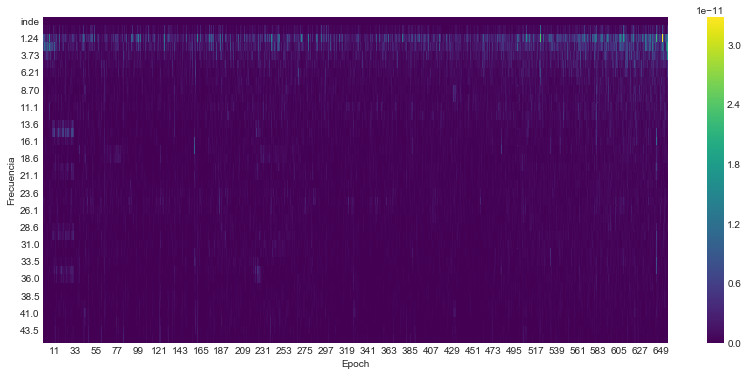

In [758]:
graph_fft(datasets_sujetos[0])

In [598]:
# Fijamos electrodos y epochs random para samplear.

min_epochs = min([(epoch_count(datasets_sujetos[i]),i) for i in range(0, len(datasets_sujetos))])
dataset_min_epochs = datasets_sujetos[min_epochs[1]]

# Decision: tomamos 20 epochs y 50 electrodos random para samplear en los casos
# donde el tiempo de ejecucion era demasiado grande.
epochs_index_random = random_epochs(dataset_min_epochs, 20)
electrodes_index_random = random_electrodes(dataset_min_epochs, 50)

In [920]:
# Devuelve la timeseries de un dataset en un epoch y electrodo dados
def get_timeseries(epoch_idx,electrodo_idx, dataset):
    return dataset[epoch_idx, electrodo_idx, :]

def par_frecuencias_potencias_epoch(epoch_idx,electrodo_idx,dataset):
    welch_result = scipy.signal.welch(get_timeseries(epoch_idx,electrodo_idx,dataset), fs=250)
    return freq_pots_relevantes(welch_result[0], welch_result[1])

# Dado un dataset y un electrodo devuelve una lista de potencias promedio para cada epoch en 'epochs_index_random'
# Por ejemplo: dados las potencias por epoch
#     epoch1 = [ pot_epoch1(freq1) , pot_epoch1(freq2) , ... ]
#     epoch2 = [ pot_epoch2(freq1) , pot_epoch2(freq2) , ... ]
#     epoch3 = [ pot_epoch3(freq1) , pot_epoch3(freq2) , ... ]
#     Devuelve un epoch_promedio = [ pot_promedio(freq1) , pot_promedio(freq2) , ... ]
def potencias_promedio(electrodo_idx,dataset):
    freqs_pots_por_epoch = [par_frecuencias_potencias_epoch(i,electrodo_idx, dataset) for i in epochs_index_random]
    res = pd.DataFrame([])
    for i in range(len(freqs_pots_por_epoch)):
        res = res.append(pd.DataFrame([freqs_pots_por_epoch[i][1]], columns=freqs_pots_por_epoch[i][0]))
    return res.mean()

In [921]:
def graph_potencias(dataset):
    colors = sns.color_palette('muted', n_colors=electrodos_count(dataset))
    for i in range(electrodos_count(dataset)):
        ax = sns.tsplot(potencias_promedio(i, dataset), color=colors[i])
        ax.set_ylabel('Potencia(V^2/Hz)')
        ax.set_xlabel('Frecuencia(Hz)')
        ax.set_xlim(right=45.0)
    plt.show()

# Punto 1.a.ii) Calcular la potencia media (entre epochs) para cada frecuencia y graficar la potencia en funcion de la frecuencia para cada canal.

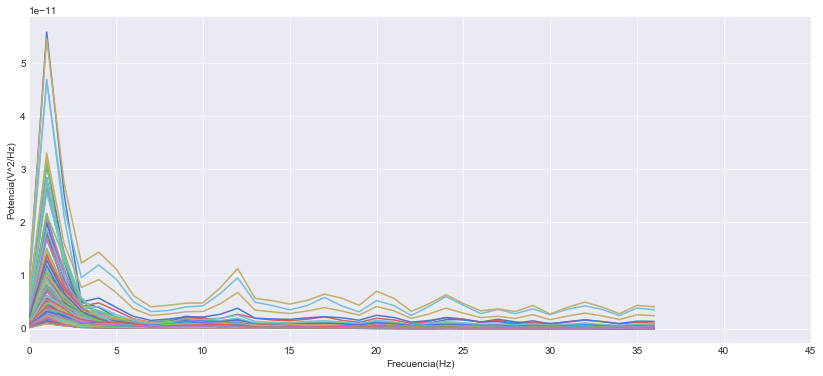

In [922]:
graph_potencias(datasets_sujetos[0])

In [584]:
def potencia_banda(low, high, potencias_promedio, frecuencias):
    # Thomas dice np.average
    return np.average(map(lambda x: x[0], ifilter(lambda x: x[1] >= low and x[1] < high, izip(potencias_promedio, frecuencias))))

def get_bandas_dict(dataset):
    potencias_promedio_by_electrode = pd.DataFrame([])
    for i in electrodes_index_random:
        pp = potencias_promedio(i, dataset)
        potencias_promedio_by_electrode = potencias_promedio_by_electrode.append(pd.Series.to_frame(pp))
    potencias_promedio_total = potencias_promedio_by_electrode.groupby(level=0).mean()
    del potencias_promedio_by_electrode
    potencias = potencias_promedio_total.values
    frecuencias = potencias_promedio_total.index.values.tolist()
    res = {}
    res['delta'] = potencia_banda(0., 4.0, potencias, frecuencias)
    res['theta'] = potencia_banda(4.0, 8.0, potencias, frecuencias)
    res['alpha'] = potencia_banda(8.0, 13.0, potencias, frecuencias)
    res['beta'] = potencia_banda(13.0, 30., potencias, frecuencias)
    res['gamma'] = potencia_banda(30.0, 125., potencias, frecuencias)
    return res

In [585]:
# Metodos entropia y kolgomorov

def to_symb(l):
    maxi = np.max(l)
    mini = np.min(l)
    def scott_N():
        std = np.std(l)
        n = float(len(l))
        return int(math.ceil((maxi - mini) / (3.5 * std * (n**(-1./3.)))))    
    N = scott_N()
    bin_size = (maxi - mini) / float(N) 
    for x in l:
        if x == maxi:
            yield N - 1
        else:
            symbol = int((x - mini) / bin_size)
            yield symbol          
            
def to_str_symb(l):
    return ''.join(imap(str, to_symb(l)))

def kolmog_approx(l):
    compressed = zlib.compress(to_str_symb(l), 9)
    return len(compressed)

def entropy(l):
    def probability(l):
        c = Counter(l)
        total = len(l)
        for x in c.items():
            yield (x[0], float(x[1]/float(total)))
    prob_dict = dict(list(probability(l)))
    return -sum(imap(lambda x: prob_dict[x] * math.log(prob_dict[x], 2), l))

def joint_entropy(l1, l2):
    return entropy(zip(l1, l2))

def mutual_information(l1, l2, l1_entropy, l2_entropy):
    return l1_entropy + l2_entropy - joint_entropy(l1, l2)

def mutual_information_2(l1, l2):
    return mutual_information(l1, l2, entropy(l1), entropy(l2))

def info_intra_electrodo(dataset):
    total = 0.
    infos = []
    for i in epochs_index_random:
        for j in electrodes_index_random:
            infos.append(kolmog_approx(get_timeseries(i, j, dataset)))
    return np.average(infos)

def info_inter_electrodo(dataset):
    total = 0.
    infos = []
    symbol_dict = {}
    entropy_dict = {}
    for i in epochs_index_random:
        for j in electrodes_index_random:
            symbol_dict[(i, j)] = to_str_symb(get_timeseries(i, j, dataset))
            entropy_dict[(i, j)] = entropy(symbol_dict[(i, j)])
    for i in epochs_index_random:
        for j in electrodes_index_random:
            for k in electrodes_index_random:
                if j < k:
                    infos.append(mutual_information(symbol_dict[(i, j)],
                                                    symbol_dict[(i, k)],
                                                    entropy_dict[(i, j)], 
                                                    entropy_dict[(i, k)]))
    return np.average(infos)

In [586]:
# PREPROCESAMIENTO

# Para cada sujeto, calcula:
# - La potencia promedio de sus bandas
# - Info intra electrodo
# - Info inter electrodo
# - Tipo (normal vs disminuido)

bandas_frame_columns = ['delta','theta','alpha','beta','gamma','info_intra','info_inter','tipo']
bandas_frame = pd.DataFrame(data=[], columns=bandas_frame_columns)

for dataset_index in range(len(datasets_sujetos)):
    bandas_dict = get_bandas_dict(datasets_sujetos[dataset_index])
    if dataset_index < len(datasets_sujetos)/2:
        bandas_dict['tipo'] = 'normal'
    else:
        bandas_dict['tipo'] = 'disminuido'
    bandas_dict['info_intra'] = info_intra_electrodo(datasets_sujetos[dataset_index])
    bandas_dict['info_inter'] = info_inter_electrodo(datasets_sujetos[dataset_index])
    bandas_sujeto = pd.DataFrame(data=[bandas_dict], columns=bandas_frame_columns)
    bandas_frame = bandas_frame.append(bandas_sujeto)

# Punto 1.b) Calcular los valores de cada banda de frecuencia, promediados entre los electrodos (todos) y epochs para cada sujeto.

In [587]:
print bandas_frame

          delta         theta         alpha          beta         gamma  \
0  4.796262e-12  9.770426e-13  6.281013e-13  4.108388e-13  2.423927e-13   
0  4.623977e-12  1.584741e-12  5.084651e-12  3.876337e-13  8.350119e-14   
0  4.999892e-12  1.186369e-12  3.880316e-12  2.013635e-13  3.340034e-14   
0  4.409534e-12  1.670331e-12  6.071092e-12  2.980775e-13  1.133469e-13   
0  4.906468e-12  1.964498e-12  3.923011e-12  3.056621e-13  4.514619e-14   
0  7.057286e-12  1.181416e-12  2.896800e-12  3.319443e-13  1.301476e-13   
0  7.054305e-12  7.874677e-13  2.652954e-12  2.898635e-13  1.129111e-13   
0  5.305551e-12  7.392322e-13  5.241899e-12  5.262418e-13  4.161217e-13   
0  2.396029e-11  6.282312e-12  4.999357e-12  1.120274e-12  2.066470e-13   
0  2.305078e-12  1.114682e-12  5.981129e-13  2.096542e-13  1.476492e-13   
0  8.626184e-12  1.044974e-12  5.448876e-13  4.860705e-13  5.997580e-13   
0  1.018807e-11  3.695733e-12  6.933643e-13  4.116327e-13  2.939472e-13   
0  1.763264e-11  1.945925

# Punto 1.c) Tomar la potencia de cada sujeto en la banda Alpha y graficar cada uno de los graficos categóricos de seaborn.
¿Cuál recomendaría para graficar y comparar distribuciones?

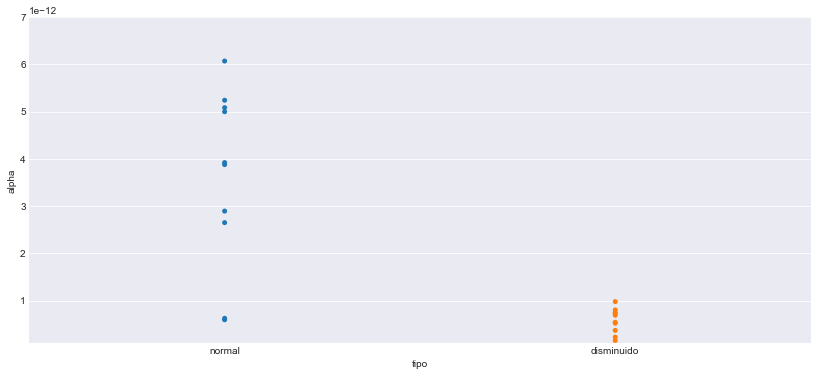

In [476]:
# Strip
sns.stripplot(data=bandas_frame, y="alpha", x="tipo")
plt.ylim(1e-13, 7e-12)
plt.show()

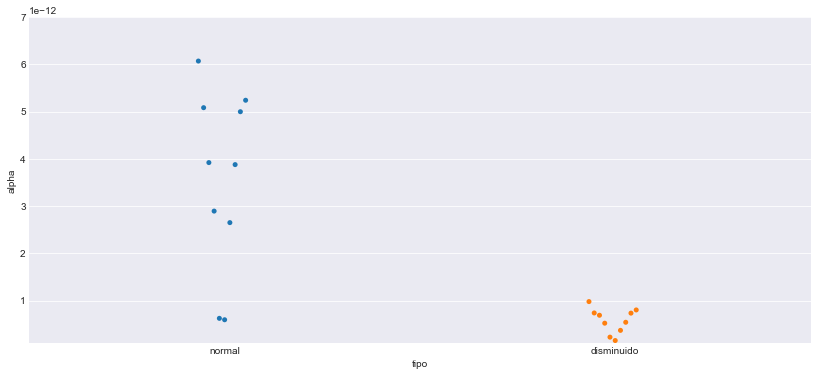

In [477]:
# Swarm
sns.swarmplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

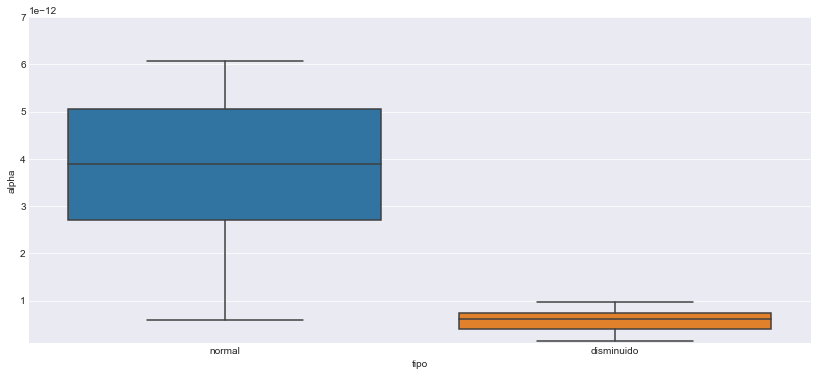

In [478]:
# Box
sns.boxplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

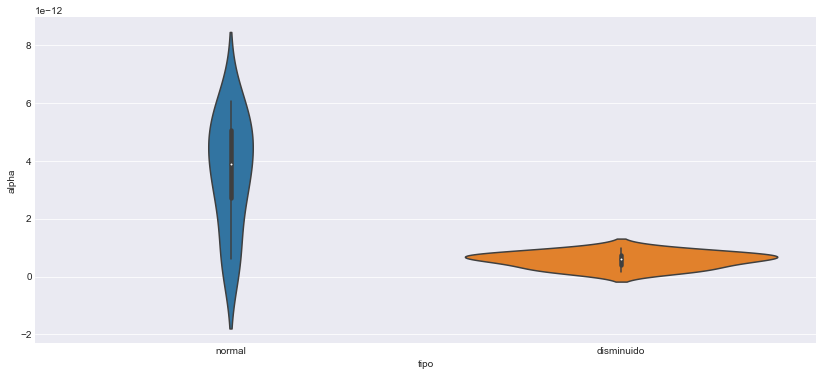

In [479]:
# Violin
sns.violinplot(x="tipo", y="alpha", data=bandas_frame)
plt.show()

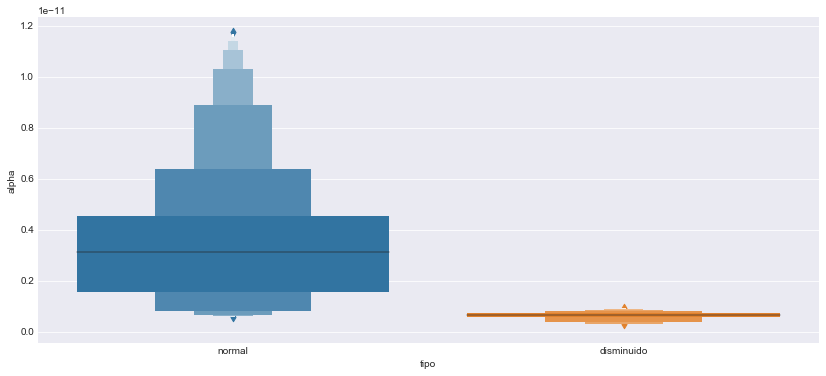

In [413]:
# LV
sns.lvplot(x="tipo", y="alpha", data=bandas_frame)
plt.show()

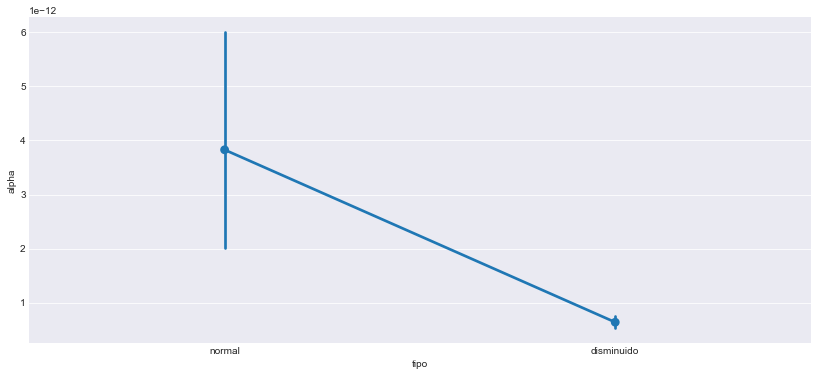

In [414]:
# Point
sns.pointplot(x="tipo", y="alpha", data=bandas_frame)
plt.show()

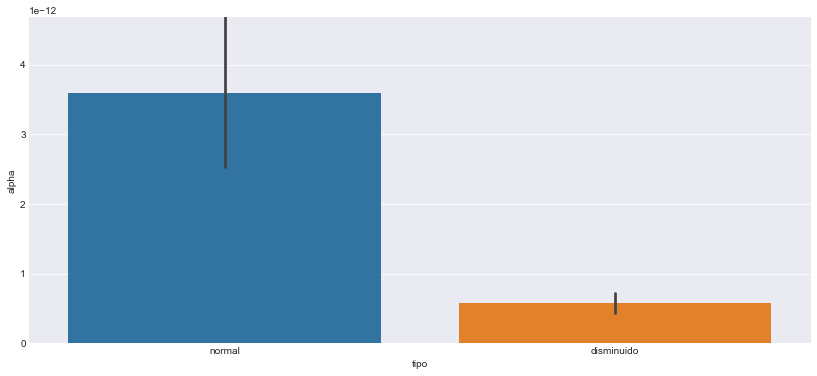

In [923]:
# Bar
sns.barplot(x="tipo", y="alpha", data=bandas_frame)
plt.show()

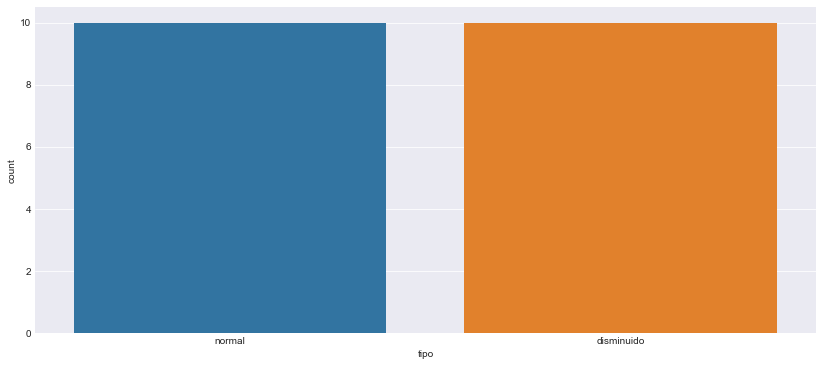

In [588]:
# Count
sns.countplot(x="tipo" ,data=bandas_frame)
plt.show()

Elegimos el grafico de Swarmplot ya que como otros graficos (ej: Boxplot) son susceptibles a manipulaciones estadisticas y los datos son relativamente pocos (10 de cada tipo), preferimos ver los datos de forma mas natural. Tambien podriamos haber elegido Violinplot, ya que muestra informacion estadistica acerca de la densidad y distribucion que podrian estar ocultos en el Boxplot.

# Punto 1.d) Para cada banda de frecuencia, graficar según lo elegido en el punto c) y realizar un test estadístico apropiado.

In [962]:
# Asume bandas_frame calculada.
# Devuelve dada una 'banda' un par de arreglos '(normales, disminuidos)'
# con la banda especificada para cada sujeto.
def get_banda_por_tipo(banda):
    cant_sujetos = len(bandas_frame)
    normales = bandas_frame[banda][0:cant_sujetos/2]
    disminuidos = bandas_frame[banda][cant_sujetos/2:cant_sujetos]
    return (normales, disminuidos)

# The Wilcoxon rank-sum test tests the null hypothesis that two sets of measurements
# are drawn from the same distribution.
# Si tenemos nivel de significacion del 0.05, rechazamos la hipotesis nula si pvalue < 0.05.
# x, y: arreglos de dos conjuntos de numeros de distribuciones no emparentadas a testear.
nivel_significacion = 0.05
def test_ranksum(x, y):
    statistic, pvalue = scipy.stats.ranksums(x, y)
    print "Test estadistico:"
    if pvalue < nivel_significacion:
        print "P-valor de: " + str(pvalue) + " indica que es poco probable que ambos conjuntos de datos vengan de la misma distribucion."
    else:
        print "P-valor de: " + str(pvalue) + " indica que no podemos rechazar que ambos conjuntos de datos vengan de la misma distribucion."

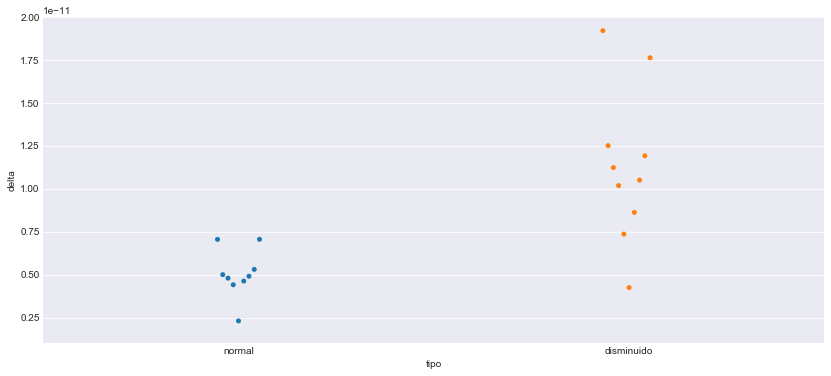

Test estadistico:
P-valor de: 0.0155644113866 indica que es poco probable que ambos conjuntos de datos vengan de la misma distribucion.


In [963]:
sns.swarmplot(x="tipo", y="delta", data=bandas_frame)
plt.ylim(1e-12, 2e-11)
plt.show()

test_ranksum(*get_banda_por_tipo("delta"))

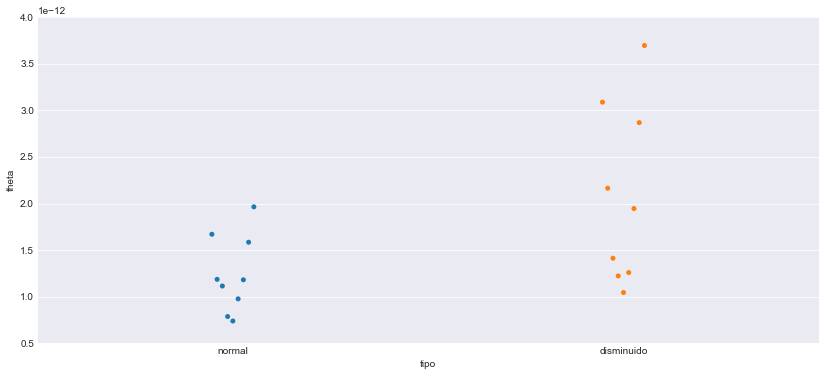

Test estadistico:
P-valor de: 0.0696424047983 indica que no podemos rechazar que ambos conjuntos de datos vengan de la misma distribucion.


In [964]:
sns.swarmplot(x="tipo", y="theta", data=bandas_frame)
plt.ylim(5e-13, 4e-12)
plt.show()

test_ranksum(*get_banda_por_tipo("theta"))

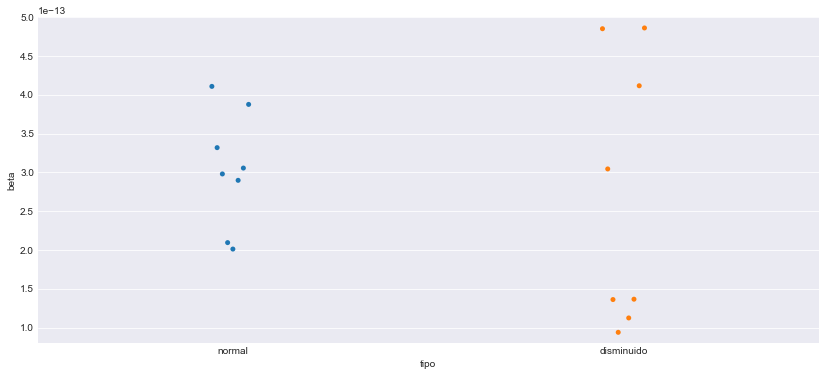

Test estadistico:
P-valor de: 0.325751354479 indica que no podemos rechazar que ambos conjuntos de datos vengan de la misma distribucion.


In [965]:
sns.swarmplot(x="tipo", y="beta", data=bandas_frame)
plt.ylim(8e-14, 5e-13)
plt.show()

test_ranksum(*get_banda_por_tipo("beta"))

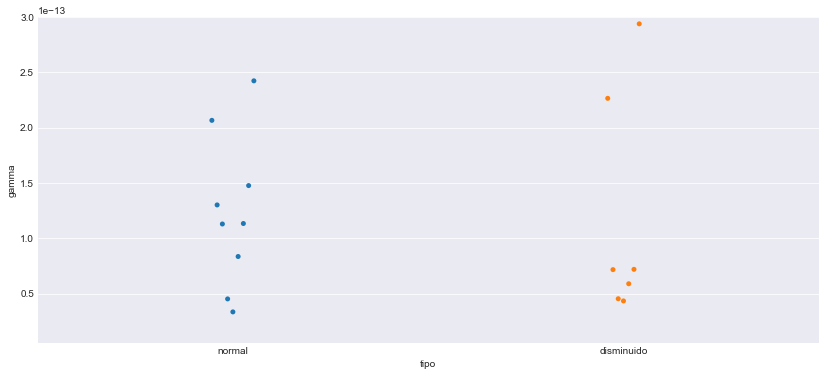

Test estadistico:
P-valor de: 0.650147444095 indica que no podemos rechazar que ambos conjuntos de datos vengan de la misma distribucion.


In [966]:
sns.swarmplot(x="tipo", y="gamma", data=bandas_frame)
plt.ylim(5e-15, 3e-13)
plt.show()

test_ranksum(*get_banda_por_tipo("gamma"))

# Punto 2.a)  Computar una medida de información intra-electrodo:
- Calcular la media entre canales y epochs para cada sujeto. 
- Realizar el gráfico elegido en el punto c) de la sección anterior, acompañado del test estadístico apropiado.

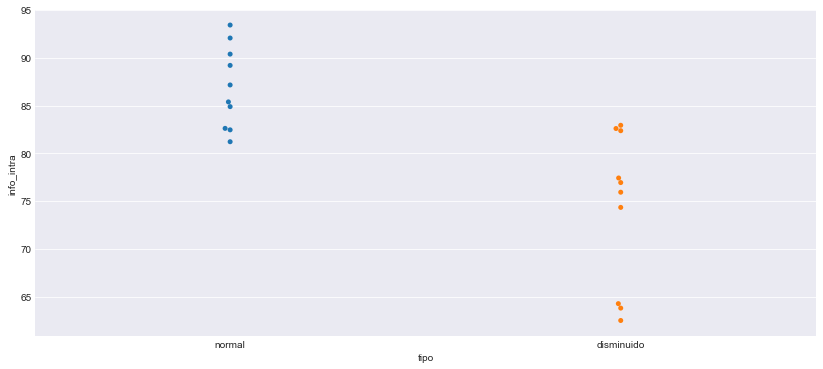

In [480]:
sns.swarmplot(x="tipo", y="info_intra", data=bandas_frame)
plt.show()

# Punto 2.b)  Repetir el punto a) para una medida inter-electrodo.

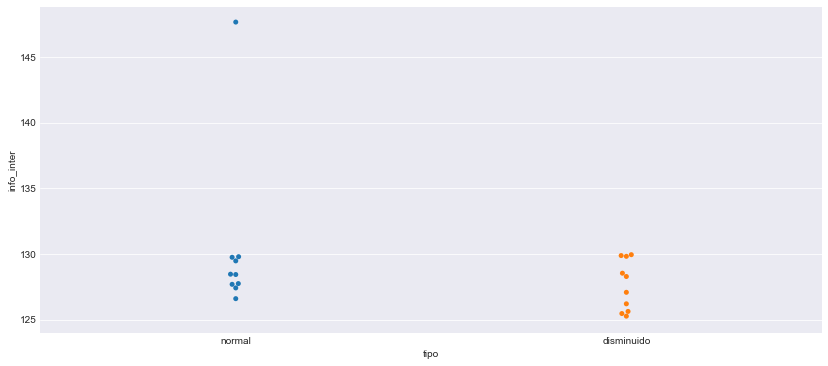

In [590]:
sns.swarmplot(x="tipo", y="info_inter", data=bandas_frame)
plt.show()